This project was based on the article [Encoding Time Series as Images](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

In [4]:
%load_ext autoreload
%autoreload 2

In [7]:
# import csv
# import json
# import math
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import pandas as pd
# import pickle
# import random
# from pylab import rcParams
# from tqdm import tqdm_notebook

# import downsample
import analysis

In [37]:
def read_csv_file (filename):
    csv_reader = csv.reader(open('%s/%s' % (config['path_data'], filename), 'r'))
    rows = np.array(list(csv_reader)[1:])
    data = [(lambda x: [ x[0].astype(int), x[1].astype(float), x[2].astype(float) ])(r) for r in rows]
    return np.array(data)

def tabulate (x, y, fn):
    return np.vectorize(fn)(*np.meshgrid(x, y, sparse=True))

def cos_sum (a, b):
    return (math.cos(a + b))

def normalize (x, x_range, t_range=(-1., 1.)):
    x_clip = np.clip(x, x_range[0], x_range[1])
    return (t_range[1] - t_range[0]) * (x_clip - x_range[0]) / (x_range[1] - x_range[0]) + t_range[0]

def process_data (x, y):
    # normalize y
    y_clip = np.clip(y, config['y_range'][0], config['y_range'][1])
    y_norm = normalize(y_clip, config['y_range'])
    
    # normalize x
    x_max = np.amax(x)
    x_min = np.amin(x)
    x_range = (x_min, x_max)
    x_norm = normalize(x, x_range, (0., 1.))
    
    # polarize time series
    gaf, phi, r = get_gaf(x_norm, y_norm)
    
    # calculate penalty score
    penalty = get_penalty(x_norm, y_clip)
    
    return (x_norm, y_norm, gaf, phi, r, penalty)

def get_gaf (x_norm, y_norm):
    # polarize time series
    phi = np.arccos(y_norm)
    r = x_norm
    
    # calculate gaf
    gaf = tabulate(phi, phi, cos_sum)
    
    return (gaf, phi, r)

def get_penalty (x, y):
    y_t = config['y_target']
    y_r0 = config['y_range'][0]
    y_r1 = config['y_range'][1]
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    y_clip = np.clip(y, y_r0, y_r1)
    y_abs = np.where(y_clip > y_t, (y_clip - y_t) / (y_r1 - y_t), (y_t - y) / (y_t - y_r0)) * config['penalty_default']
    y_cold = np.where(y_th0 and y_clip < y_th0, (y_th0 - y_clip) / (y_th0 - y_r0), 0) * config['penalty_cold']
    y_warm = np.where(y_th1 and y_clip > y_th1, (y_clip - y_th1) / (y_r1 - y_th1), 0) * config['penalty_warm']
    
    penalty_default = np.trapz(y_abs, x)
    penalty_cold = np.trapz(y_cold, x)
    penalty_warm = np.trapz(y_warm, x)
    penalty_total = (penalty_default + penalty_cold + penalty_warm) / config['penalty_max']
    penalty_norm = normalize(penalty_total, (0., 1.), (1., 1024.))
    score = 10. - math.log(penalty_norm) / math.log(2)
    mkt = get_mkt(x, y)
    
    return {
        'penalty_default': penalty_default / config['penalty_default'],
        'penalty_cold': penalty_cold / config['penalty_cold'],
        'penalty_warm': penalty_warm / config['penalty_warm'],
        'penalty_total': penalty_total,
        'mkt': mkt,
        'score': score
    }

def get_intervals (values):
    intervals = []
    for i in range(len(values)):
        intervals.append(0. if i == 0 else values[i] - values[i-1])
    return intervals
    
def get_mkt (x, y, dhr=14508):
#     (83.11472 / 8.31446261815324)
    y_t = config['y_target']
    y_r1 = config['y_range'][1]
    y_clip = np.clip(y, y_t, y_r1)
    x_i = get_intervals(x)
    y_k = y_clip + 273.5
    denominator = -np.log(np.sum(x_i * np.exp(-dhr / y_k)) / np.sum(x_i))
    return dhr / denominator - 273.15

def plot_score (penalty):
    score = penalty['score']
    color_default = [ *config['color_default'][:-1], 0.2 ]
    color_score = config['color_score']
    colors = (color_score, color_default)
    
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle('Total Score: %0.1f out of 10' % score, fontsize=16)
    
    ax = fig.add_subplot(111)
    ax.set_xlim(0., 10.)
    ax.set_ylim(0., 10.)
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    ax.set_yticks([4])
    ax.set_yticklabels([''])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.broken_barh([ (0., score), (score, 10. - score) ], [2, 4], facecolors=colors)

def plot_penalty (penalty):
    pm = config['penalty_max']
    pd = penalty['penalty_default'] * 100. / pm
    pw = penalty['penalty_warm'] * 100. / pm
    pc = penalty['penalty_cold'] * 100. / pm
    pt = pd + pw + pc
    pdt = pd * 100. / pt
    pwt = pw * 100. / pt
    pct = pc * 100. / pt
    color_standard = config['color_standard']
    color_warm = config['color_warm']
    color_cold = config['color_cold']
    colors = (color_standard, color_warm, color_cold)
    
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle('Penalty Breakdown', fontsize=16)

    ax = fig.add_subplot(111)
    ax.set_xlim(0., 100.)
    ax.set_ylim(0., 10.)
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    ax.set_yticks([4])
    ax.set_yticklabels([''])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.broken_barh([ (0, pdt), (pdt, pwt), (pdt+pwt, pct) ], [2, 4], facecolors=colors)

    leg1 = mpatches.Patch(color=color_standard, label='%0.1f%% standard' % pdt)
    leg2 = mpatches.Patch(color=color_warm, label='%0.1f%% warm' % pwt)
    leg3 = mpatches.Patch(color=color_cold, label='%0.1f%% cold' % pct)
    ax.legend(handles=[leg1, leg2, leg3], ncol=3)

def plot_line (x, y, ax=None, area=True, alpha=1.0):
    y_t = config['y_target']
    y_r0 = config['y_range'][0]
    y_r1 = config['y_range'][1]
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.set_ylim(config['y_range'] or (np.amin(y), np.amax(y)))
    ax.plot([0., 1.], [y_t, y_t], dashes=(2, 3), c=config['color_default'])
    if area:
        ax.fill_between(x, y1=y, y2=y_t, color=config['color_standard'], alpha=0.2)
    
    if y_th0:
        y_cold = np.where(y < y_th0, y, y_th0)
        ax.plot([0., 1.], [y_th0, y_th0], dashes=(4, 4), c=config['color_cold'])
        if area:
            ax.fill_between(x, y1=y_cold, y2=y_th0, color=config['color_cold'], alpha=0.2)
    if y_th1:
        y_warm = np.where(y > y_th1, y, y_th1)
        ax.plot([0., 1.], [y_th1, y_th1], dashes=(4, 4), c=config['color_warm'])
        if area:
            ax.fill_between(x, y1=y_warm, y2=y_th1, color=config['color_warm'], alpha=0.2)
    
    ax.plot(x, y, c=config['color_default'], alpha=alpha)
    
    return ax

def plot_decay (y, mkt, ax=None):
    y_r0 = config['y_range'][0]
    y_r1 = config['y_range'][1]
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(211)
    ax.set_xlim(0, 40)
    ax.set_ylim(1, 100)
    ax.set_yscale('log')

    ax.plot([0, 40], [400, 1.5], color='red')
    ax.scatter(mkt, y, s=500, alpha=0.5)

def plot_polar (phi, r, ax=None):
    y_r = config['y_range']
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    y_target_norm = normalize(config['y_target'], y_r)
    y_th0_norm = normalize(y_th0, y_r)
    y_th1_norm = normalize(y_th1, y_r)
    phi_target = np.arccos(y_target_norm)
    phi_th0 = np.arccos(y_th0_norm)
    phi_th1 = np.arccos(y_th1_norm)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, polar=True)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_xticks(np.pi / 180. * np.linspace(180, 0, 4, endpoint=False))
    ax.fill_betweenx(r, np.pi - phi_target, np.pi - phi, color=config['color_standard'], alpha=0.2)
    ax.plot([np.pi - phi_target, np.pi - phi_target], [0, 1], dashes=(2, 3), c=config['color_default'])
    
    if y_th0:
        phi_cold = np.where(phi > phi_th0, phi, phi_th0)
        ax.fill_betweenx(r, np.pi - phi_th0, np.pi - phi_cold, color=config['color_cold'], alpha=0.2)
        ax.plot([np.pi - phi_th0, np.pi - phi_th0], [0, 1], dashes=(4, 4), c=config['color_cold'])
    if y_th1:
        phi_warm = np.where(phi < phi_th1, phi, phi_th1)
        ax.fill_betweenx(r, np.pi - phi_th1, np.pi - phi_warm, color=config['color_warm'], alpha=0.2)
        ax.plot([np.pi - phi_th1, np.pi - phi_th1], [0, 1], dashes=(4, 4), c=config['color_warm'])
    
    ax.plot(np.pi - phi, r, c=config['color_default'])
    
    return ax

def plot_gaf (gaf):
    # Gramian Angular Field
    plt.matshow(gaf)
    
def plot_all (data, score=False, line=False, polar=False, gaf=False):
    if score:
        plot_score(data['penalty'])    
        plot_penalty(data['penalty'])
    if line:
        plot_line(data['x_norm'], data['y'])
    if polar:
        plot_polar(data['phi'], data['r'])
    if gaf:
        plot_gaf(data['gaf'])

In [56]:
report = reporting.load_all_report()

loaded 184 data frames
loaded 53 data frames


In [49]:
result = {}
if os.path.isfile(config['path_result']):
    print('loading results from cache "%s"' % config['path_result'])
    result = reporting.load_report_result()

data = reporting.load_device_report()
result = reporting.get_report_result(result, data)

loading results from cache "data/819a5bb0-b47a-11e8-bed9-a7787a7e5890_result.pkl.gz"


FileNotFoundError: [Errno 2] No such file or directory: '%s/%s_result.pkl.gz'

In [50]:
report

{'420c4af0':                time  temperature  humidity
 0     1557727734000         7.86     97.84
 1     1557728334000         7.67     97.31
 2     1557728934000         7.51     96.99
 3     1557729534000         7.37     96.69
 4     1557730134000         7.21     96.15
 5     1557730734000         7.35     97.79
 6     1557731334000         7.26     97.19
 7     1557731934000         7.30     97.16
 8     1557732534000         7.21     96.75
 9     1557733134000         7.11     95.89
 10    1557733734000         7.02     95.40
 11    1557734334000         6.95     95.16
 12    1557734934000         6.54     94.57
 13    1557735534000         6.01     94.02
 14    1557736134000         5.57     93.94
 15    1557736734000         5.22     93.91
 16    1557737334000         4.89     94.00
 17    1557737934000         4.70     94.19
 18    1557738534000         4.48     94.37
 19    1557739134000         4.32     94.60
 20    1557739734000         4.17     94.79
 21    1557740334000

In [122]:
data = generate_data({ **config, "volatility": (0.00, 0.05) })
# for i, x in enumerate(data):
#     print('index %d: score: %0.1f%%' % (i, x['penalty']['score']))
# plot_all(data[3])

total devices: 24
average penalty_default: 0.098527
average penalty_cold: 0.004736
average penalty_warm: 0.013907
average penalty_total: 0.016897
average mkt: 7.603160
average score: 6.366343


,device id,default penalty,warm penalty,cold penalty,mkt,score
0,42088f34,0.022605,0.002169,0.000000,5.998849,8.090682
1,42090f93,0.033116,0.000260,0.000000,5.462155,7.849089
2,42098fc2,0.033750,0.001519,0.000000,6.475813,7.747983
3,42080494,0.048079,0.000143,0.000000,6.891157,7.427664
4,4208227e,0.053300,0.000943,0.000000,7.060292,7.267611
5,4208e39a,0.048416,0.005246,0.000000,7.045598,7.187235
6,42090031,0.058449,0.001941,0.000000,7.202415,7.117089
7,42088938,0.062313,0.001069,0.000000,7.094393,7.075257
8,420a9066,0.055014,0.005278,0.000000,7.235733,7.053694
9,420fe311,0.064636,0.000695,0.000000,7.431534,7.044952


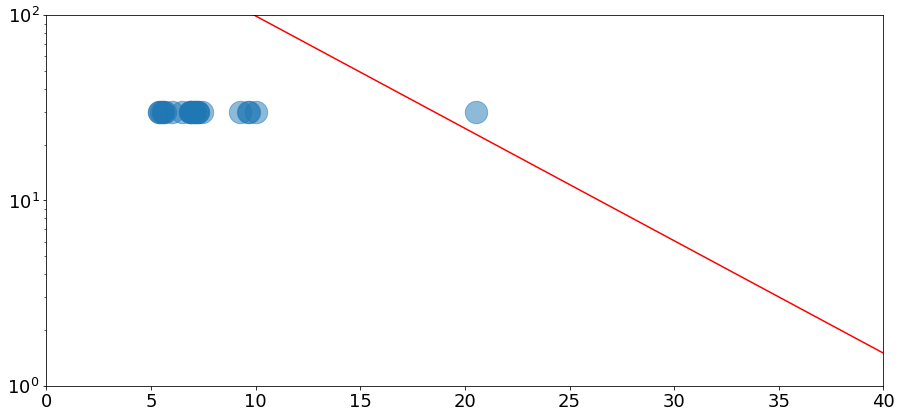

In [44]:
result_pd = print_report_result(result)

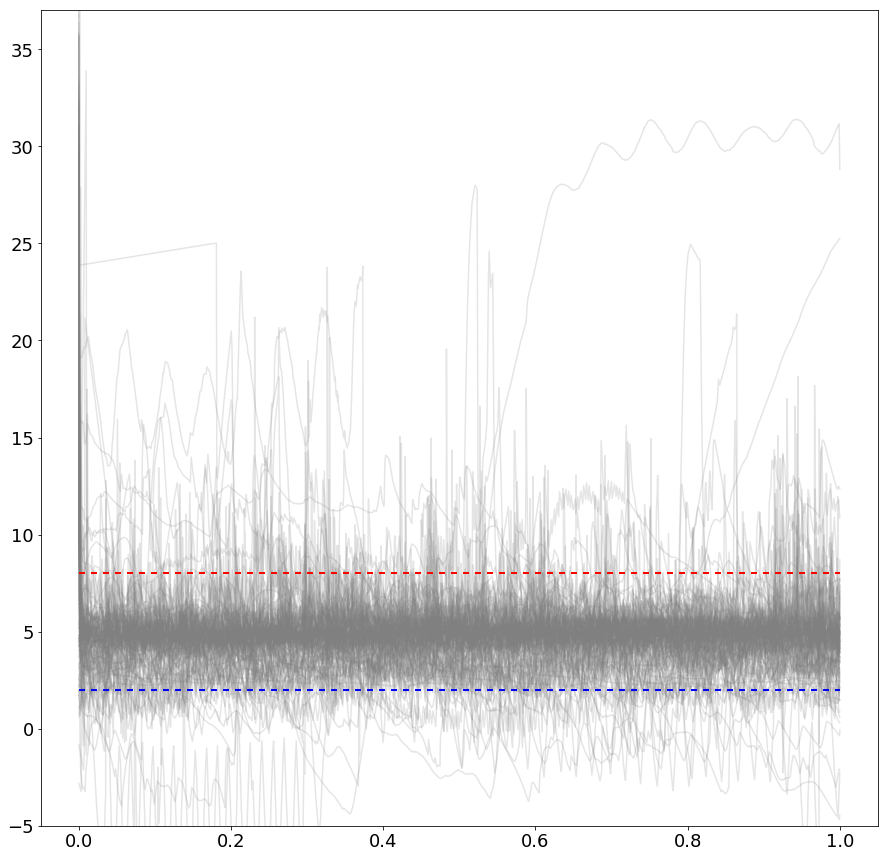

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
for device_id, device_report in result.items():
    plot_line(device_report['x_norm'], device_report['y'], ax=ax, area=False, alpha=0.2)

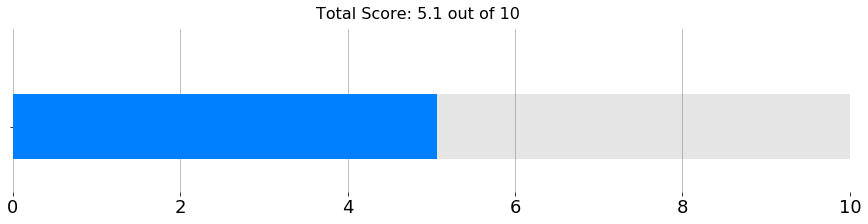

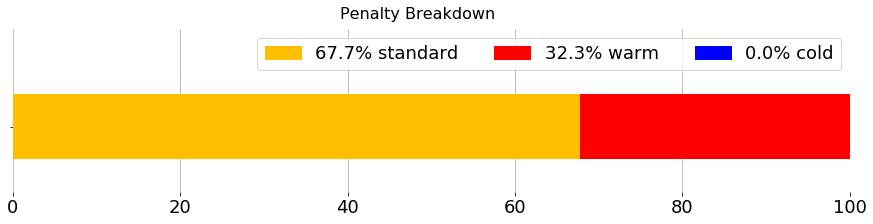

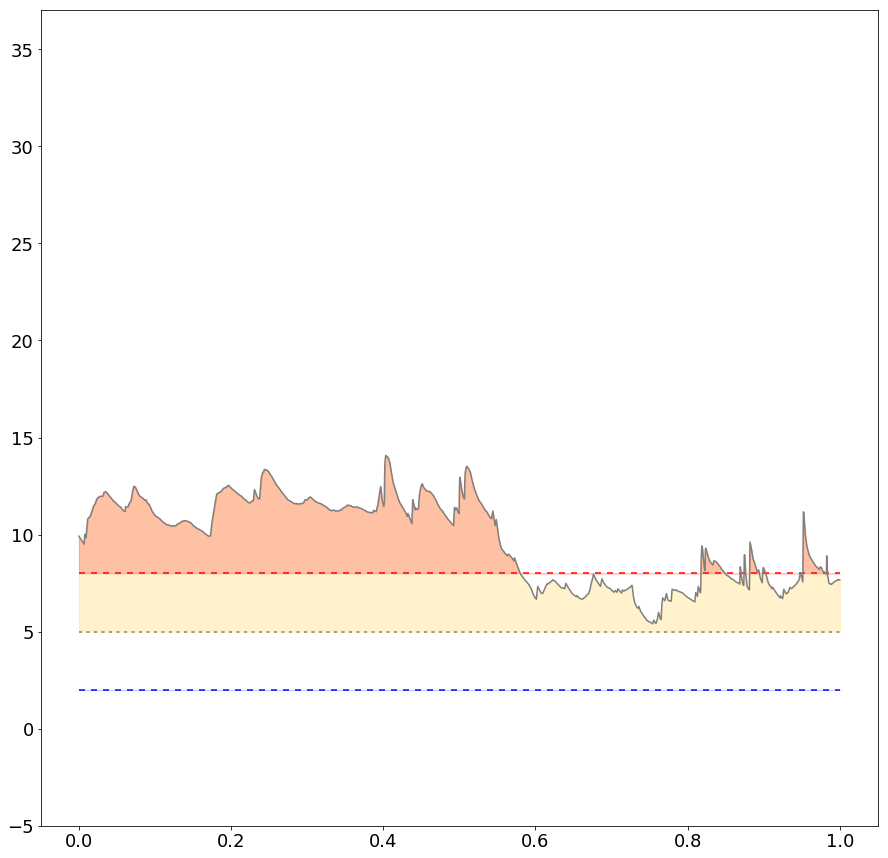

In [106]:
plot_all(result['4209f4f2'], polar=False, gaf=False)

total devices: 24
average penalty_default: 0.098527
average penalty_cold: 0.004736
average penalty_warm: 0.013907
average penalty_total: 0.016897
average mkt: 7.480195
average score: 6.366343


,device id,default penalty,warm penalty,cold penalty,mkt,score
0,42088f34,0.022605,0.002169,0.000000,5.892588,8.090682
1,42090f93,0.033116,0.000260,0.000000,5.457970,7.849089
2,42098fc2,0.033750,0.001519,0.000000,6.453126,7.747983
3,42080494,0.048079,0.000143,0.000000,6.890245,7.427664
4,4208227e,0.053300,0.000943,0.000000,7.056425,7.267611
5,4208e39a,0.048416,0.005246,0.000000,7.006301,7.187235
6,42090031,0.058449,0.001941,0.000000,7.194107,7.117089
7,42088938,0.062313,0.001069,0.000000,7.077181,7.075257
8,420a9066,0.055014,0.005278,0.000000,7.204374,7.053694
9,420fe311,0.064636,0.000695,0.000000,7.425890,7.044952


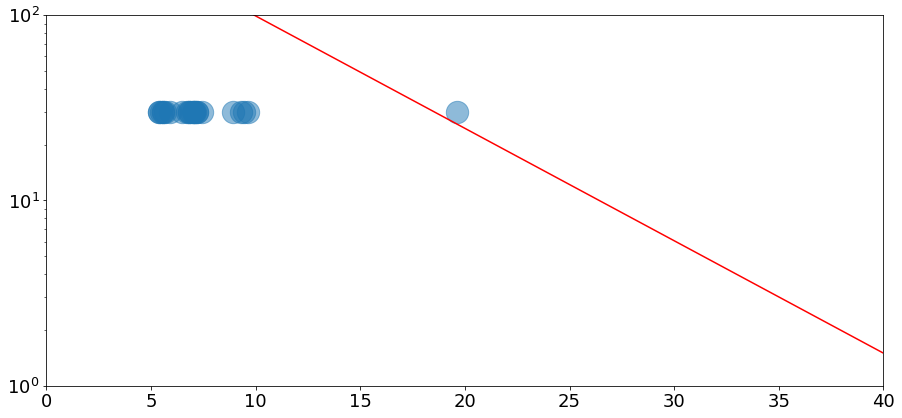

In [24]:
print_report_result(result)

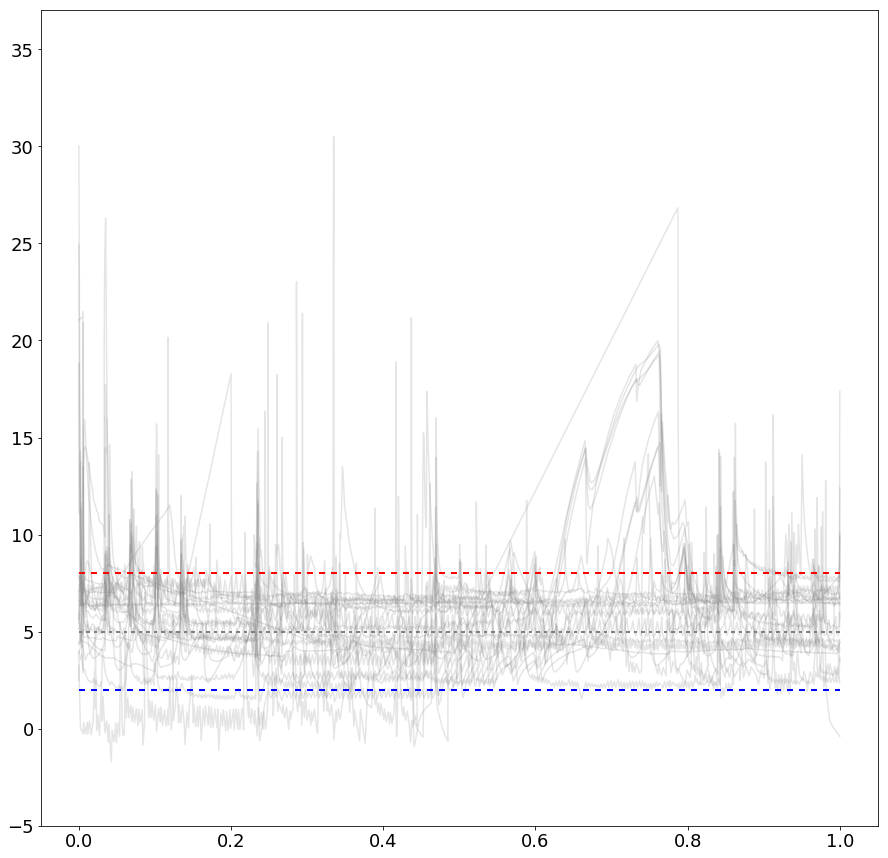

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
for device_id, device_report in result.items():
    plot_line(device_report['x_norm'], device_report['y'], ax=ax, area=False, alpha=0.2)

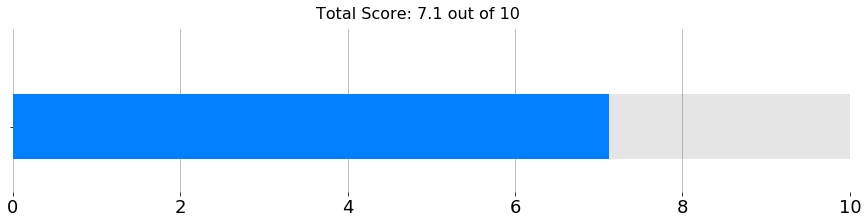

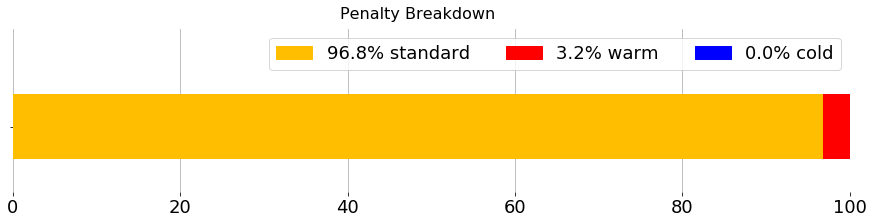

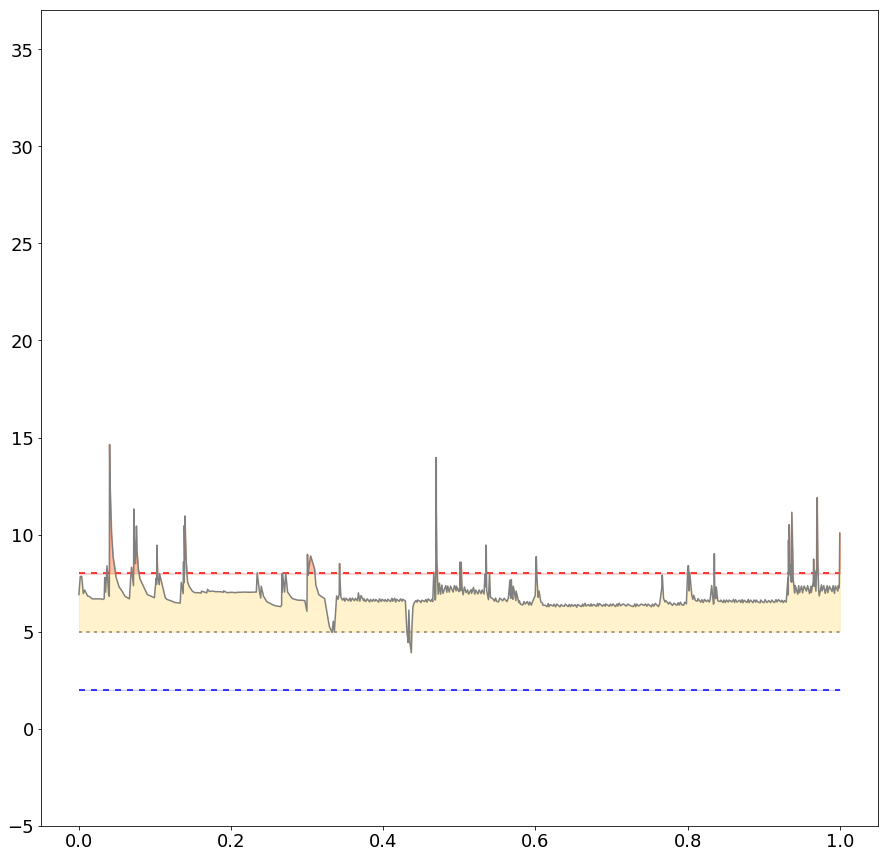

In [92]:
plot_all(result['42090031'], polar=False, gaf=False)

In [3]:
print('  hello')

  hello
